In [171]:
!pip install transformers
!unzip data_sets.zip

unzip:  cannot find or open data_sets.zip, data_sets.zip.zip or data_sets.zip.ZIP.


In [172]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
import random
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig, AutoTokenizer, TFBertModel
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
import heapq
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
from google.colab import drive
drive.mount('/content/drive')

# BERT is pretrained with a max length of 512, you can define a lower max length ~ 300
MAX_LEN = 512 
PRETRAINED_MODEL_ID = "bert-base-uncased"
tf.random.set_seed(
    42
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [173]:
def loadRawData(path):
  '''
  loads reviews as strings in a list 
  ---- your code here ------
  '''
  x_train = []
  x_test = []
  y_train = []
  y_test = []
  
  for file in os.listdir(path+'/training_set/pos/'):
     with open(path+'/training_set/pos/'+file) as myfile:
       raw_data = myfile.read()
       x_train.append(raw_data)
       y_train.append(1)

  for file in os.listdir(path+'/training_set/neg/'):
     with open(path+'/training_set/neg/'+file) as myfile:
       raw_data = myfile.read()
       x_train.append(raw_data)
       y_train.append(0)

  for file in os.listdir(path+'/test_set/pos/'):
     with open(path+'/test_set/pos/'+file) as myfile:
       raw_data = myfile.read()
       x_test.append(raw_data)
       y_test.append(1)

  for file in os.listdir(path+'/training_set/neg/'):
     with open(path+'/training_set/neg/'+file) as myfile:
       raw_data = myfile.read()
       x_test.append(raw_data)
       y_test.append(0)
  
  shuffled_indicies = np.random.permutation(len(x_train))
  x_train1 = []
  y_train1 = []
  for i in shuffled_indicies:
    x_train1.append(x_train[i])
    y_train1.append(y_train[i])
  
  x_train = x_train1
  y_train = y_train1

  x_train = np.array(x_train)
  y_train = np.array(y_train)
  x_test = np.array(x_test)
  y_test = np.array(y_test)

  return x_train, x_test, y_train, y_test


The following function represents the reviews in a format accepted by BERT

In [174]:
### Already implemented
def create_inputs_targets(text_examples, tokenizer):
    '''converts inputs into the representation accepted by BERT
    '''
    dataset_dict = {
        "input_ids": [],
        
        "attention_mask": []
    }
    
    for item in text_examples:
        encodings = tokenizer(item, return_tensors='tf', max_length = MAX_LEN, truncation = True, pad_to_max_length=True)
        
        dataset_dict["input_ids"].append((encodings.input_ids))
        dataset_dict["attention_mask"].append((encodings.attention_mask))
    
    for key in dataset_dict:
        dataset_dict[key] = np.squeeze(np.array(dataset_dict[key]), axis=1)
           
    x = [
        dataset_dict["input_ids"],
     
        dataset_dict["attention_mask"]
    ]
    
    return x


 We will use TFBertForSequenceClassification. This interface  enables us to load a pretrained BERT model with an added untrained single linear layer on top for classification that we will use as a classifier. We will finetune the entire pre-trained BERT model and the additional untrained classification layer for our Movie Review classification task. 

In [175]:

## Already Implemented
def create_bert(args):
    '''Creates a model specified by pretrained_model_id

    '''
    # load pretrained BERT model 
    
    
    model = TFBertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_ID, num_labels = 2 )
    
    
    # BERT inputs 
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32)
    
    embedding = model(
            input_ids,  attention_mask=attention_mask
        )[0]
 
    model = keras.Model(
        inputs=[input_ids, attention_mask],
        outputs=[embedding],
    )
    # from_logits=True computes the "softmax" activation as part of the cross-entropy loss layer
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = keras.optimizers.Adam(lr=args['learning_rate'])
    metrics = keras.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
    return model




    

We will also compare to an MLP on BOW representation learnt in NaiveBayes Section. You can reuse code from HW3 for this portion.

In [176]:
def create_mlp(args=None):
	# You can use args to pass parameter values to this method
  # Define model architecture
  input_shape=(100,)
  model = keras.Sequential()
  # model.add(keras.layers.Dense(units=512, activation="sigmoid", input_dim=28*28))
	# add more layers...
  # model.add(keras.layers.Dense(units=256, activation="sigmoid", input_dim=512))
  model.add(keras.layers.Dense(units=128, activation="sigmoid", input_shape=input_shape))
  model.add(keras.layers.Dense(units=64, activation="sigmoid"))
  model.add(keras.layers.Dense(units=32, activation="sigmoid"))
  model.add(keras.layers.Dense(units=1, activation="sigmoid"))

	# add more layers...

	# Optimizer
  optimizer = keras.optimizers.Adam(lr=args['learning_rate'])
	 
	# Compile
  model.compile(loss="binary_crossentropy", optimizer= keras.optimizers.Adam(learning_rate=0.00005), metrics=['accuracy'])
  
  return model
		


def plot_history(history, plot_title=''):
    train_loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']

    train_acc_history = history.history['accuracy']
    val_acc_history = history.history['val_accuracy']
    # plot
    plt.title('training loss and validation loss vs epoch number')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.plot(train_acc_history)
    plt.plot(val_acc_history)
    plt.show()
    plt.plot(train_loss_history)
    plt.plot(val_loss_history)
    plt.title('training accuracy and validation accuracy vs epoch number')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()
    

def train_model(x_train, y_train, model_type, validation_split=0.1, args=None):
    # You can use args to pass parameter values to this method
    if model_type == 'BERT':
      model = create_bert(args)
      history = model.fit((x_train[0], x_train[1]), y_train, batch_size=args['batch_size'], validation_split=args['validation_split'], epochs=10, shuffle=True)
    else:
      model = create_mlp(args)
      history = model.fit(x_train, y_train, batch_size=args['batch_size'], validation_split=args['validation_split'], epochs=15, shuffle=True)
    return model, history


In [177]:
def train_and_select_model(x_train, y_train, model_type, grading_mode):
    """Optional method. You can write code here to perform a 
    parameter search, cross-validation, etc. """

    # you can define hyperparameters differently for BERT and MLP using if else. Note that for BERT, the architecture is fixed and no changes are required. 
    # you are free to change the learning rate, batch size, etc. for BERT. 

    args = {
        'batch_size': 8,
        'validation_split': 0.1,
				'epoch': 2,
        'learning_rate': 0.00001
    }
    
    best_valid_acc = 0
    best_hyper_set = {}
    
    ## Select best values for hyperparamters such as learning_rate, optimizer, hidden_layer, hidden_dim, regularization...
    if not grading_mode:
      if model_type == 'BERT':
        best_model, best_history = train_model(x_train, y_train, model_type, validation_split=args['validation_split'], args=args)
      else:
        args = {
        'batch_size': 8,
        'validation_split': 0.1,
				'epoch': 10,
        'learning_rate': 0.01
        }
        best_model, best_history = train_model(x_train, y_train, model_type, validation_split = args['validation_split'], args=args)

    else:
      if model_type == 'BERT':
        args = {
        'batch_size': 8,
        'validation_split': 0.1,
				'epoch': 2,
        'learning_rate': 0.00001
        }
        best_model, best_history = train_model(x_train, y_train, model_type, validation_split = args['validation_split'], args=args)
      else:
        args = {
        'batch_size': 8,
        'validation_split': 0.1,
				'epoch': 2,
        'learning_rate': 0.03
        }
        best_model, best_history = train_model(x_train, y_train, model_type, validation_split = args['validation_split'], args=args)
        
        
            
        
    return best_model, best_history

Now, we will train both models and compare performance. 

In [178]:


def processData(fullDatasetPath, model_type):
  
  # we will use the bert-base-uncased tokenizer - 
  if model_type == 'BERT':
    # load datasets as lists of reviews
    # no preprocessing required!
    # we will use the bert-base-uncased tokenizer - 
    XtrainText, XtestText, ytrain, ytest = loadRawData(fullDatasetPath)
    tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_ID)
    
    # tokenize for bert
    xtrain = create_inputs_targets(XtrainText, tokenizer)
    ytrain = np.array(ytrain)

    xtest = create_inputs_targets(XtestText, tokenizer)
    ytest = np.array(ytest)
    return xtrain, xtest, ytrain, ytest
    
  else:
    # reuse data loading functions from NaiveBayes portions, you can optionally save the BOW matrices and reload here 
    XtrainText, XtestText, ytrain, ytest, vocabulary = loadData(fullDatasetPath)
    MIN_FREQ = 3
    MAX_VOCAB = 100
    vocabulary = dict((word, index) for word, index in vocabulary.items() if vocabulary[word]>=MIN_FREQ and word in heapq.nlargest(MAX_VOCAB, vocabulary, key=vocabulary.get))
    xtrain, xtest = getBOWRepresentation(XtrainText, XtestText, vocabulary) 
    return np.array(xtrain), np.array(xtest), np.array(ytrain), np.array(ytest)
    
  # return xtrain, xtest, ytrain, ytest



In [179]:
def loadData(path):
  '''
  loads reviews as strings in a list 
  ---- your code here ------
  '''
  x_train = []
  x_test = []
  y_train = []
  y_test = []
  vocab_builder = []
  vocabulary ={}
  
  for file in os.listdir(path+'/training_set/pos/'):
     with open(path+'/training_set/pos/'+file) as myfile:
       review = myfile.read()
       review = re.sub(r'[^\w\s]', '', review)
       review_tokens = tokenizer.tokenize(review.lower())
       review_tokens = [review for review in review_tokens if not review in stop_words]
       review_tokens = [ps.stem(review) for review in review_tokens]
       x_train.append(review_tokens)
       y_train += [1]
       vocab_builder += review_tokens
  
  for file in os.listdir(path+'/training_set/neg/'):
    with open(path+'/training_set/neg/'+file) as myfile:
      read_file = myfile.read()
      review = re.sub(r'[^\w\s]', '', read_file)
      review_tokens = tokenizer.tokenize(review.lower())
      review_tokens = [review for review in review_tokens if not review in stop_words]
      review_tokens = [ps.stem(review) for review in review_tokens]
      x_train.append(review_tokens)
      y_train += [0]
      vocab_builder += review_tokens
  
  for file in os.listdir(path+'/test_set/pos/'):
    with open(path+'/test_set/pos/'+file) as f:
      read_file = f.read()
      review = re.sub(r'[^\w\s]', '', read_file)
      review_tokens = tokenizer.tokenize(review.lower())
      review_tokens = [review for review in review_tokens if not review in stop_words]
      review_tokens = [ps.stem(review) for review in review_tokens]
      x_test.append(review_tokens)
      y_test += [1]
      vocab_builder += review_tokens
  
  for file in os.listdir(path+'/test_set/neg/'):
    with open(path+'/test_set/neg/'+file) as myfile:
      read_file = myfile.read()
      review = re.sub(r'[^\w\s]', '', read_file)
      review_tokens = tokenizer.tokenize(review.lower())
      review_tokens = [review for review in review_tokens if not review in stop_words]
      review_tokens = [ps.stem(review) for w in review_tokens]
      x_test.append(review_tokens)
      y_test += [0]
      vocab_builder += review_tokens
  
  for word in vocab_builder:
    if word in vocabulary.keys():
      vocabulary[word]=vocabulary[word]+1
    else:
      vocabulary[word]=1
      
  shuffle = np.random.permutation(len(x_train))
  x_train = [x_train[i] for i in shuffle]
  y_train = [y_train[i] for i in shuffle]
  
  return x_train, x_test, y_train, y_test, vocabulary

def getBOWRepresentation(x_train, x_test, vocabulary):
  '''
  converts into Bag of Words representation
  each column is a feature(unique word) from the vocabulary 
  x_train_bow : a numpy array with bag of words representation
  '''
  # --------your code here-------------
  x_train_bow = []
  x_test_bow = []
  for text_data in x_train:
    x_train_bow.append(transfer(text_data, list(vocabulary)))
  for text_data in x_test:
    x_test_bow.append(transfer(text_data, list(vocabulary)))
  x_train_bow = np.array(x_train_bow)
  x_test_bow = np.array(x_test_bow)
  return np.array(x_train_bow), np.array(x_test_bow)

def transfer(review, vocabulary):
  temp_list = [0]*len(vocabulary)
  for word in review:
    if word in vocabulary:
      index = vocabulary.index(word)
      temp_list[index] += 1
  return temp_list


# Finetune pretrained BERT and train MLP from scratch.

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


158/158 [==============================] - 331s 2s/step - loss: 0.6305 - accuracy: 0.6476 - val_loss: 0.5126 - val_accuracy: 0.7500
Epoch 2/10
158/158 [==============================] - 307s 2s/step - loss: 0.3690 - accuracy: 0.8500 - val_loss: 0.3977 - val_accuracy: 0.8214
Epoch 3/10
158/158 [==============================] - 307s 2s/step - loss: 0.2172 - accuracy: 0.9190 - val_loss: 0.3175 - val_accuracy: 0.8643
Epoch 4/10
158/158 [==============================] - 307s 2s/step - loss: 0.0981 - accuracy: 0.9683 - val_loss: 0.3670 - val_accuracy: 0.8857
Epoch 5/10
158/158 [==============================] - 307s 2s/step - loss: 0.0535 - accuracy: 0.9857 - val_loss: 0.4597 - val_accuracy: 0.8714
Epoch 6/10
158/158 [==============================] - 307s 2s/step - loss: 0.0486 - accuracy: 0.9849 - val_loss: 0.3879 - val_accuracy: 0.8786
Epoch 7/10
158/158 [==============================] - 316s 2s/step - loss: 0.0198 - accuracy: 0.9968 - val_loss: 0.4804 - val_accuracy: 0.8643
Epoch 8/10

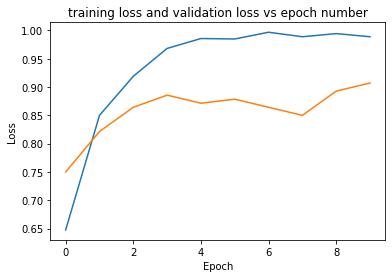

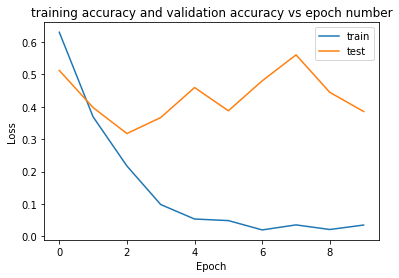

0.9729999899864197
Epoch 1/15
158/158 [==============================] - 2s 6ms/step - loss: 0.7685 - accuracy: 0.4968 - val_loss: 0.7138 - val_accuracy: 0.5286
Epoch 2/15
158/158 [==============================] - 1s 5ms/step - loss: 0.7133 - accuracy: 0.4968 - val_loss: 0.6930 - val_accuracy: 0.5286
Epoch 3/15
158/158 [==============================] - 1s 5ms/step - loss: 0.6961 - accuracy: 0.4968 - val_loss: 0.6896 - val_accuracy: 0.5286
Epoch 4/15
158/158 [==============================] - 1s 5ms/step - loss: 0.6910 - accuracy: 0.5063 - val_loss: 0.6894 - val_accuracy: 0.5571
Epoch 5/15
158/158 [==============================] - 1s 5ms/step - loss: 0.6891 - accuracy: 0.5976 - val_loss: 0.6894 - val_accuracy: 0.5929
Epoch 6/15
158/158 [==============================] - 1s 5ms/step - loss: 0.6878 - accuracy: 0.6183 - val_loss: 0.6892 - val_accuracy: 0.5857
Epoch 7/15
158/158 [==============================] - 1s 5ms/step - loss: 0.6867 - accuracy: 0.6135 - val_loss: 0.6883 - val_accu

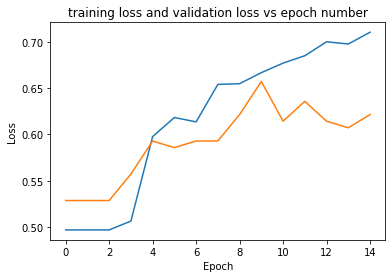

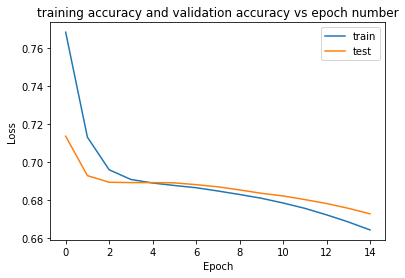

0.846666693687439


In [180]:
grading_mode = True
path = '/content/drive/My Drive/data_sets/'

if grading_mode:
  # BERT model 
  xtrain, xtest, ytrain, ytest = processData(path, 'BERT')
  model, history = train_and_select_model(xtrain, ytrain, 'BERT', grading_mode=True)
  loss_test, acc_test = model.evaluate(xtest, ytest)
  plot_history(history)
  print(acc_test)
  # MLP model
  xtrain, xtest, ytrain, ytest = processData(path, 'MLP')
  model, history = train_and_select_model(xtrain, ytrain, 'MLP', grading_mode=True)
  loss_test, acc_test = model.evaluate(xtest, ytest)
  plot_history(history)
  print(acc_test)

else:
  # BERT model 
  xtrain, xtest, ytrain, ytest = processData(path, 'BERT')
  model, history = train_and_select_model(xtrain, ytrain, 'BERT', grading_mode=False)
  loss_test, acc_test = model.evaluate(xtest, ytest)
  plot_history(history)

  # MLP model
  xtrain, xtest, ytrain, ytest = processData(path, 'MLP')
  model, history = train_and_select_model(xtrain, ytrain, 'MLP', grading_mode=False)
  loss_test, acc_test = model.evaluate(xtest, ytest)
  plot_history(history)